In [1]:
from sklearn.preprocessing import LabelEncoder
import json
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
import seaborn as sns

In [15]:
data_path_train = "oye_combined_augmented.json"  # Train verisi
data_path_test = "oye_combined.json"  # Test verisi
#data_path_train = "oye_augmented.json"  # Train verisi
#data_path_test = "oye.json"  # Test verisi

In [14]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["features"])
    y = np.array(data["labels"])
    return X, y

In [4]:
def prepare_dataset(validation_size):
    X_train, y_train = load_data(data_path_train)  # Augmented dataset
    X_test, y_test = load_data(data_path_test)  # Orijinal dataset

    # Validation set oluşturma
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    print("Unique labels train:", np.unique(y_train))
    print("Unique labels val:", np.unique(y_validation))
    print("Unique labels test:", np.unique(y_test))
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)  # Etiketleri düzelt
    y_validation = encoder.transform(y_validation)
    y_test = encoder.transform(y_test)  # Aynı dönüşümü test setine uygula

    print("after encoder")
    print("Unique labels train:", np.unique(y_train))
    print("Unique labels val:", np.unique(y_validation))
    print("Unique labels test:", np.unique(y_test))
    
    # expected 3d array for each sample -> (130, 13, 1) 130 time bins, 13 mfcc features, 1 gray scale
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1)
    X_validation = X_validation[..., np.newaxis] 
    X_test = X_test[..., np.newaxis] 
     
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [5]:
def build_model(input_shape):
    model = keras.Sequential()

    # 1. Conv Block
    model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    # 2. Conv Block
    model.add(keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    # 3. Conv Block
    model.add(keras.layers.Conv2D(128, (2, 2), activation="relu", padding="same"))
    model.add(keras.layers.MaxPooling2D((2, 2), padding="same"))
    model.add(keras.layers.BatchNormalization())

    # Dense Layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))

    # Output Layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model


In [6]:
def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [7]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [8]:
from sklearn.metrics import f1_score


def calculate_f1_score(model, X_test, y_test):
    # Modelin tahminlerini al
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Softmax çıktılarını sınıf indeksine çevir

    # Confusion matrix oluştur
    cm = confusion_matrix(y_test, y_pred)

    # F1-score’u hesapla
    f1_scores = f1_score(y_test, y_pred, average=None)  # Her sınıf için ayrı F1-score
    f1_scores_percent = f1_scores * 100

    # F1-score’ları yüzde olarak yazdır
    for i, score in enumerate(f1_scores_percent):
        print(f"Sınıf {i} için F1-score: %{score:.2f}")


    return cm, f1_scores

In [9]:
def plot_f1_scores(f1_scores, class_labels):
    """ F1-score'ları çubuk grafikte gösterir. """

    plt.figure(figsize=(10, 5))

    # Check if the length of f1_scores matches the length of class_labels
    if len(f1_scores) != len(class_labels):
        print("Error: Length of f1_scores and class_labels must be the same.")
        return  # Exit the function if lengths don't match

    sns.barplot(x=class_labels, y=f1_scores, palette="viridis")

    plt.xlabel("Sınıf")
    plt.ylabel("F1-Score")
    plt.title("Sınıf Bazında F1-Skorları")
    plt.ylim(0, 1)  # F1-score 0 ile 1 arasında olmalı
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [10]:
from sklearn.metrics import recall_score


def calculate_recall(model, X_test, y_test):
    """ Modelin test setindeki tahminlerine göre recall hesaplar. """

    # Modelin tahminlerini al
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Softmax çıktılarını sınıf indeksine çevir

    # Recall hesapla
    recall_scores = recall_score(y_test, y_pred, average=None)  # Her sınıf için ayrı recall

    recall_scores_percent = recall_scores * 100

    # Recall’ları yüzde olarak yazdır
    for i, score in enumerate(recall_scores_percent):
        print(f"Sınıf {i} için Recall: %{score:.2f}")


    return recall_scores

In [11]:
def plot_recall_scores(recall_scores):
    """ Recall skorlarını çubuk grafikte gösterir. """

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(range(len(recall_scores))), y=recall_scores, palette="magma")

    plt.xlabel("Sınıf")
    plt.ylabel("Recall")
    plt.title("Sınıf Bazında Recall Skorları")
    plt.ylim(0, 1)  # Recall 0 ile 1 arasında olmalı
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

Unique labels train: [ 0  1  2  3  4  5  7  8  9 10]
Unique labels val: [ 0  1  2  3  4  5  7  8  9 10]
Unique labels test: [ 0  1  2  3  4  5  7  8  9 10]
after encoder
Unique labels train: [0 1 2 3 4 5 6 7 8 9]
Unique labels val: [0 1 2 3 4 5 6 7 8 9]
Unique labels test: [0 1 2 3 4 5 6 7 8 9]
(31958, 130, 25, 1)
130
25
1


C:\Users\EREN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 86ms/step - accuracy: 0.2782 - loss: 2.0162 - val_accuracy: 0.4880 - val_loss: 1.5179
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.4498 - loss: 1.5591 - val_accuracy: 0.5791 - val_loss: 1.2482
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.5122 - loss: 1.3891 - val_accuracy: 0.6184 - val_loss: 1.1405
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.5672 - loss: 1.2479 - val_accuracy: 0.6507 - val_loss: 1.0348
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.6109 - loss: 1.1285 - val_accuracy: 0.6817 - val_loss: 0.9322
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.6596 - loss: 1.0149 - val_accuracy: 0.6980 - val_loss: 0.8943
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.6814 - loss: 0.9360 - val_accuracy: 0.7267 - val_loss: 0.8171
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.7062 - loss: 0.8519 - 

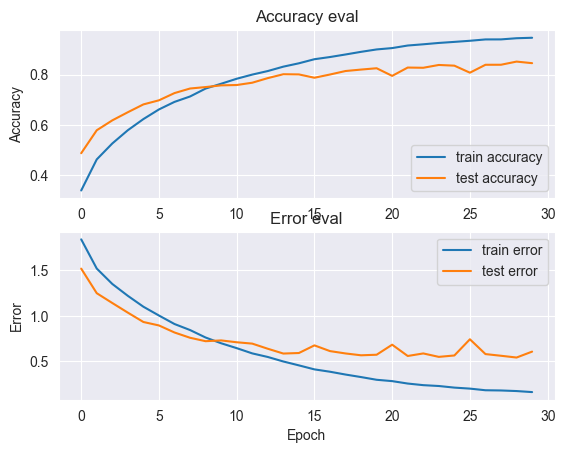

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9844 - loss: 0.0590
Accuracy on test set is 0.9801722168922424


In [16]:
    if __name__ == "__main__":
    
    # create train, validation, and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.2)

    print(X_train.shape)
    print(X_train.shape[1])
    print(X_train.shape[2])
    print(X_train.shape[3])

    # build the CNN net
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # (num_samples, 130, 25, 1)
    model = build_model(input_shape)
    
    
    # compile the network 
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy",
                 metrics=['accuracy'])
    
    # train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=30)

    plot_history(history)

    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on test set is {}".format(test_accuracy))



313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


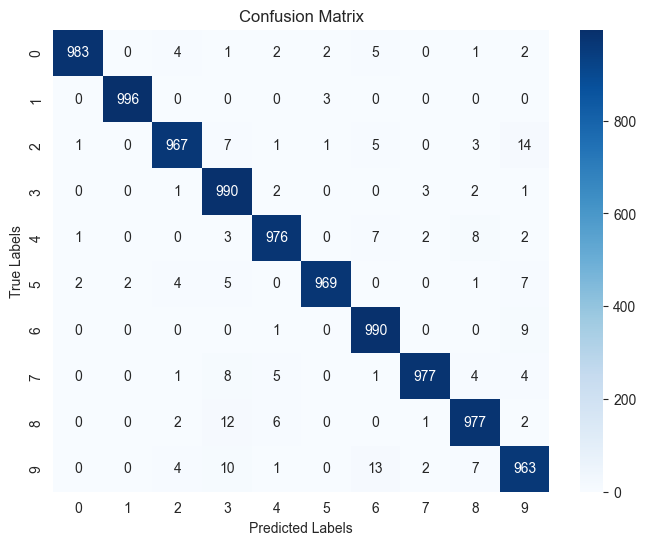

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1000
           1       1.00      1.00      1.00       999
           2       0.98      0.97      0.98       999
           3       0.96      0.99      0.97       999
           4       0.98      0.98      0.98       999
           5       0.99      0.98      0.99       990
           6       0.97      0.99      0.98      1000
           7       0.99      0.98      0.98      1000
           8       0.97      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.98      9986
   macro avg       0.98      0.98      0.98      9986
weighted avg       0.98      0.98      0.98      9986

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Sınıf 0 için F1-score: %98.94
Sınıf 1 için F1-score: %99.75
Sınıf 2 için F1-score: %97.58
Sınıf 3 için F1-score: %97.30
Sınıf 4 için F1-score: %97.94
Sınıf 5 için F1-score: %98.63
Sınıf 6 için F1-sco

C:\Users\EREN\AppData\Local\Temp\ipykernel_3792\1971398374.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=f1_scores, palette="viridis")


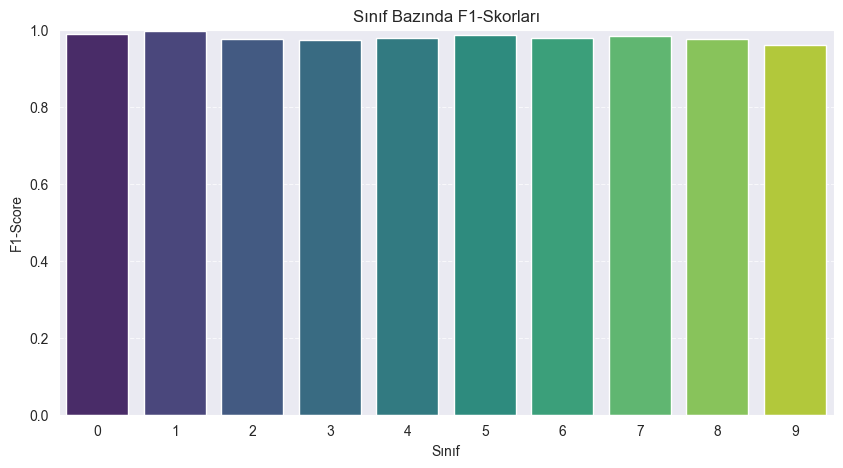

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Sınıf 0 için Recall: %98.30
Sınıf 1 için Recall: %99.70
Sınıf 2 için Recall: %96.80
Sınıf 3 için Recall: %99.10
Sınıf 4 için Recall: %97.70
Sınıf 5 için Recall: %97.88
Sınıf 6 için Recall: %99.00
Sınıf 7 için Recall: %97.70
Sınıf 8 için Recall: %97.70
Sınıf 9 için Recall: %96.30


C:\Users\EREN\AppData\Local\Temp\ipykernel_3792\3362363030.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(recall_scores))), y=recall_scores, palette="magma")


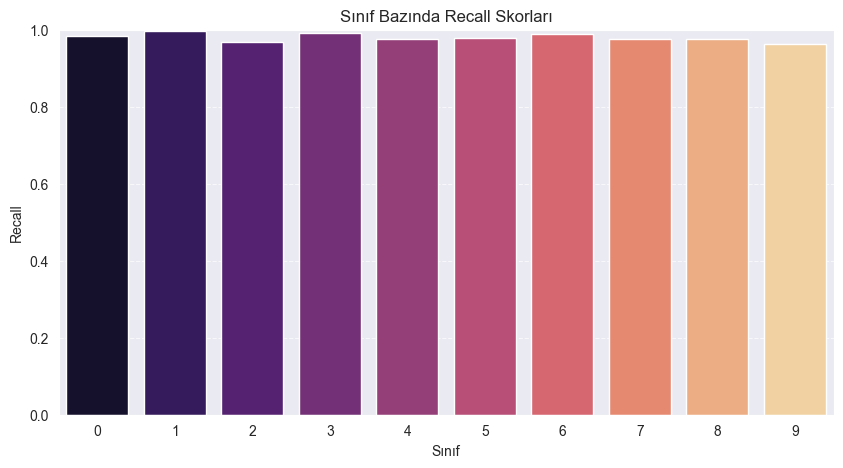

In [17]:
from sklearn.metrics import classification_report

# Modelin tahminleri
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
class_labels = [str(i) for i in range(10)]  # 0-10 arası sınıflar varsayıldı
plot_confusion_matrix(y_test, y_pred, class_labels)

# Classification Report
print(classification_report(y_test, y_pred, target_names=class_labels))

# Test sonrası
cm, f1_scores = calculate_f1_score(model, X_test, y_test)

# F1-score plot
plot_f1_scores(f1_scores, class_labels)


# Recall hesapla
recall_scores = calculate_recall(model, X_test, y_test)

# Recall görselleştir
plot_recall_scores(recall_scores)

Unique labels train: [ 0  1  2  3  4  5  7  8  9 10]
Unique labels val: [ 0  1  2  3  4  5  7  8  9 10]
Unique labels test: [ 0  1  2  3  4  5  7  8  9 10]
after encoder
Unique labels train: [0 1 2 3 4 5 6 7 8 9]
Unique labels val: [0 1 2 3 4 5 6 7 8 9]
Unique labels test: [0 1 2 3 4 5 6 7 8 9]
(31958, 130, 13, 1)
130
13
1


C:\Users\EREN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.2887 - loss: 2.0166 - val_accuracy: 0.5353 - val_loss: 1.4051
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.4606 - loss: 1.5318 - val_accuracy: 0.5957 - val_loss: 1.2008
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.5428 - loss: 1.3260 - val_accuracy: 0.6532 - val_loss: 1.0457
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.5997 - loss: 1.1643 - val_accuracy: 0.6814 - val_loss: 0.9507
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6392 - loss: 1.0518 - val_accuracy: 0.7073 - val_loss: 0.8809
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.6723 - loss: 0.9672 - val_accuracy: 0.7249 - val_loss: 0.8154
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7065 - loss: 0.8603 - val_accuracy: 0.7390 - val_loss: 0.7771
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.7333 - loss: 0.7831 - 

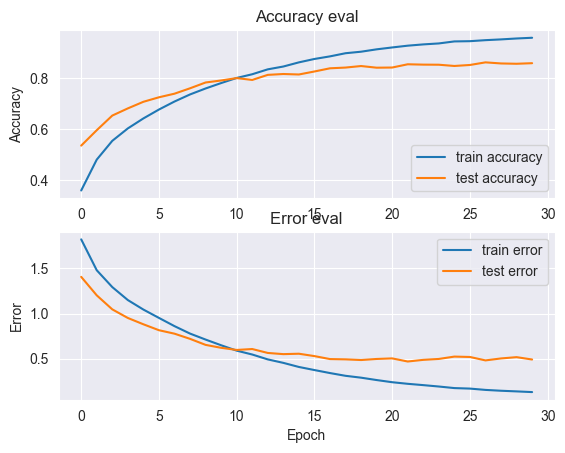

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9871 - loss: 0.0459
Accuracy on test set is 0.983877420425415


In [12]:
if __name__ == "__main__":

    # mfcc only
    # create train, validation, and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.2)

    print(X_train.shape)
    print(X_train.shape[1])
    print(X_train.shape[2])
    print(X_train.shape[3])

    # build the CNN net
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # (num_samples, 130, 25, 1)
    model = build_model(input_shape)


    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

    # train the CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=30)

    plot_history(history)

    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print("Accuracy on test set is {}".format(test_accuracy))



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


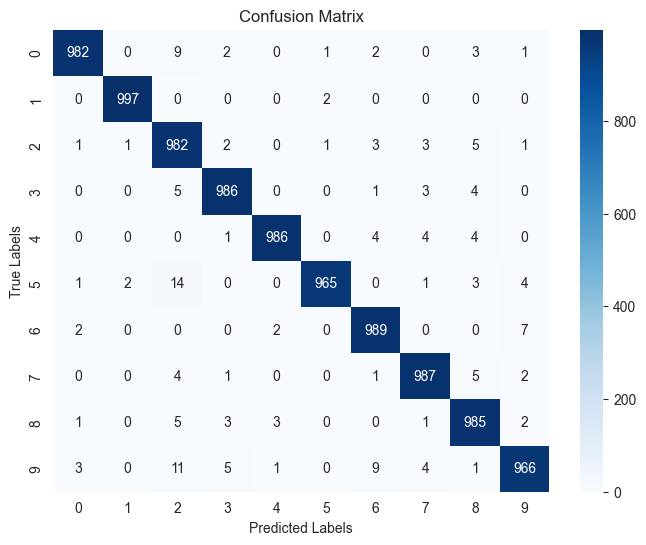

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1000
           1       1.00      1.00      1.00       999
           2       0.95      0.98      0.97       999
           3       0.99      0.99      0.99       999
           4       0.99      0.99      0.99       999
           5       1.00      0.97      0.99       990
           6       0.98      0.99      0.98      1000
           7       0.98      0.99      0.99      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.98      9986
   macro avg       0.98      0.98      0.98      9986
weighted avg       0.98      0.98      0.98      9986

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Sınıf 0 için F1-score: %98.69
Sınıf 1 için F1-score: %99.75
Sınıf 2 için F1-score: %96.80
Sınıf 3 için F1-score: %98.65
Sınıf 4 için F1-score: %99.05
Sınıf 5 için F1-score: %98.52
Sınıf 6 için F1-scor

C:\Users\EREN\AppData\Local\Temp\ipykernel_3792\1971398374.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=f1_scores, palette="viridis")


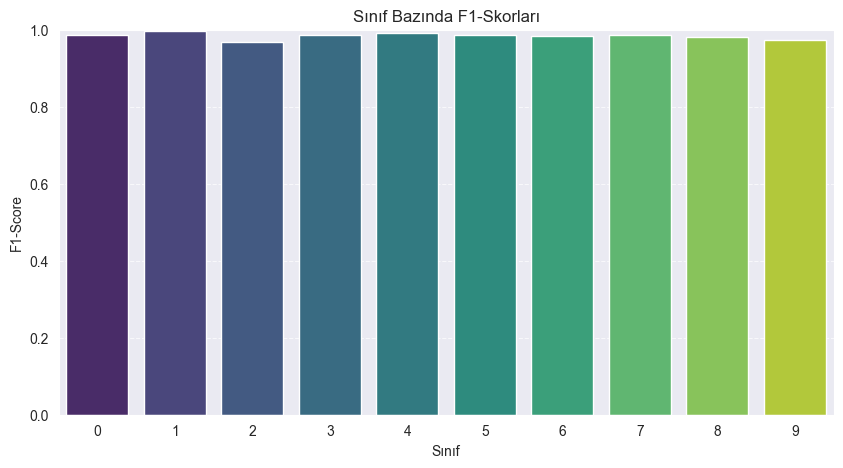

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Sınıf 0 için Recall: %98.20
Sınıf 1 için Recall: %99.80
Sınıf 2 için Recall: %98.30
Sınıf 3 için Recall: %98.70
Sınıf 4 için Recall: %98.70
Sınıf 5 için Recall: %97.47
Sınıf 6 için Recall: %98.90
Sınıf 7 için Recall: %98.70
Sınıf 8 için Recall: %98.50
Sınıf 9 için Recall: %96.60


C:\Users\EREN\AppData\Local\Temp\ipykernel_3792\3362363030.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(recall_scores))), y=recall_scores, palette="magma")


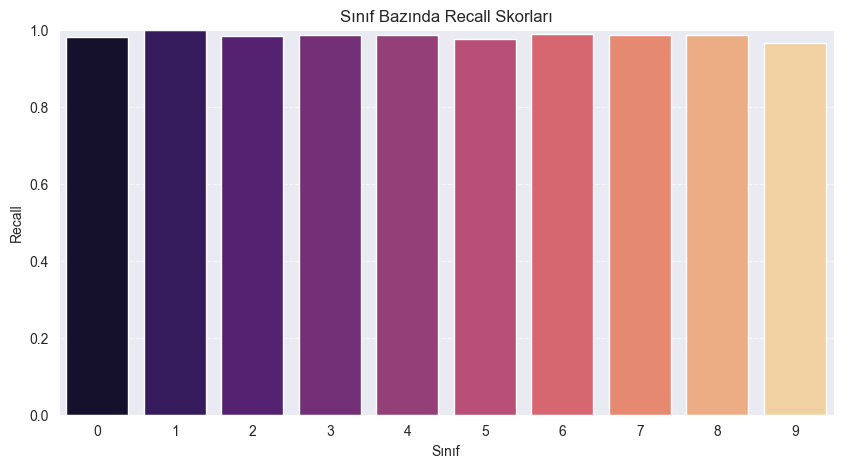

In [13]:
from sklearn.metrics import classification_report

# mfcc only

# Modelin tahminleri
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
class_labels = [str(i) for i in range(10)]  # 0-10 arası sınıflar varsayıldı
plot_confusion_matrix(y_test, y_pred, class_labels)

# Classification Report
print(classification_report(y_test, y_pred, target_names=class_labels))

# Test sonrası
cm, f1_scores = calculate_f1_score(model, X_test, y_test)

# F1-score plot
plot_f1_scores(f1_scores, class_labels)


# Recall hesapla
recall_scores = calculate_recall(model, X_test, y_test)

# Recall görselleştir
plot_recall_scores(recall_scores)